# Validación y Selección

### Selección del mejor modelo entrenado en 03_ModelTraining

In [3]:
import os
import sys
# Añadir src al path para importar los scripts
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
#  Imports del script
from train import (
    load_and_prepare_data
)

#  Cargar y preparar datos
print("Cargando y preparando datos para LTV_180...")
X_train_ltv, y_train_ltv, X_val_ltv, y_val_ltv, X_test_ltv, y_test_ltv = load_and_prepare_data(
    path="../data/processed/final_dataset.csv",
    target="LTV_180",
    date_column="first_session"
)

print("Cargando y preparando datos para CAC_source_30...")
X_train_cac, y_train_cac, X_val_cac, y_val_cac, X_test_cac, y_test_cac = load_and_prepare_data(
    path="../data/processed/final_dataset.csv",
    target="CAC_source_30",
    date_column="first_session"
)

Cargando y preparando datos para LTV_180...
Cargando y preparando datos para CAC_source_30...


In [4]:
from IPython.display import display
import joblib
from evaluation import evaluate_all

def load_models(folder: str, target: str):
    models = {}
    for file in os.listdir(folder):
        if target in file and file.endswith(".pkl"):
            name = file.replace(f"{target}_", "").replace(".pkl", "")
            path = os.path.join(folder, file)
            models[name] = joblib.load(path)
    return models

cac_models = load_models("../models/", "CAC_source_30")
ltv_models = load_models("../models/", "LTV_180")

# 3. Evaluar modelos
print("\nEvaluación de modelos: LTV_180")
ltv_results = evaluate_all(ltv_models, X_val_ltv, y_val_ltv)
display(ltv_results.sort_values("MAPE").round(4).style.background_gradient())

print("\nEvaluación de modelos: CAC_source_30")
cac_results = evaluate_all(cac_models, X_val_cac, y_val_cac)
display(cac_results.sort_values("MAPE").round(4).style.background_gradient())



Evaluación de modelos: LTV_180


/home/pablo-herrera/Documents/USFQ/8vo/DataMining/Proyecto_final/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pablo-herrera/Documents/USFQ/8vo/DataMining/Proyecto_final/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,MAE,RMSE,MAPE
Model,,,
rf,0.088100,2.176000,0.172000
rf_best_tscv,0.098900,2.588000,0.177300
lgb,0.770300,16.850100,2.244200
xgb,0.165100,2.179800,2.301500
best_tscv,0.156500,2.948000,4.978900
cat,0.574900,17.218800,14.177900
ridge,3.238600,5.325200,201.171500
linear,3.240400,5.326700,201.343300
stacking,3.476300,5.183600,232.695000



Evaluación de modelos: CAC_source_30


/home/pablo-herrera/Documents/USFQ/8vo/DataMining/Proyecto_final/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pablo-herrera/Documents/USFQ/8vo/DataMining/Proyecto_final/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,MAE,RMSE,MAPE
Model,,,
stacking,2764.265400,3927.841200,66.357300
rf,2498.004100,3587.999700,66.738000
best_tscv,2837.095800,4046.893200,67.216300
lgb,2904.049400,4110.178600,67.482500
cat,2879.008600,4110.869700,68.038200
xgb,2733.684800,3892.321000,71.052400
linear,3590.678300,4618.769600,73.026900
ridge,3590.854200,4618.944400,73.027600
sgd,5797309.463500,7629539.212700,194700.929600


Random Forest (rf) se posiciona como el mejor modelo en ambos casos analizados (LTV_180 y CAC_source_30), liderando en métricas clave como MAE y RMSE, y mostrando el MAPE más bajo para LTV. Su rendimiento consistente, combinado con su simplicidad y robustez frente a otras alternativas más complejas o inestables, lo convierten en la opción más sólida y pragmática para estas tareas.

### Optimización LTV_180

In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, mean_absolute_percentage_error
import joblib
import numpy as np

X_train = X_train_ltv
y_train = y_train_ltv
X_val = X_val_ltv
y_val = y_val_ltv
X_test = X_test_ltv
y_test = y_test_ltv

print(f"Tamaño X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Tamaño X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Tamaño X_test: {X_test.shape}, y_test: {y_test.shape}")

# Preprocesamiento 
num_cols = X_train.select_dtypes(include=['number']).columns.tolist() # Usar 'number' es más general
cat_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print(f"Columnas numéricas para preprocesar: {num_cols}")
print(f"Columnas categóricas para preprocesar: {cat_cols}")

numeric_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categoric_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False puede ser mejor para RF
])

preprocess = ColumnTransformer([
    ('num', numeric_tf, num_cols),
    ('cat', categoric_tf, cat_cols)
], remainder='drop') # 'drop' es más explícito si estás seguro de cubrir todas las features


# Definición del Pipeline con RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1) # n_jobs=-1 para usar todos los cores

full_pipe_rf = Pipeline([
    ('preprocess', preprocess),
    ('model', rf_model)
])

# Configuración de GridSearchCV para RandomForestRegressor
# TimeSeriesSplit se aplicará sobre X_train para la validación cruzada interna de GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False) # Queremos minimizar MAE

# Hiperparámetros para RandomForestRegressor
# param_grid_rf = {
#     "model__n_estimators": [100, 200, 300],       # Número de árboles
#     "model__max_depth": [10, 20, None],           # Profundidad máxima (None = sin límite)
#     "model__min_samples_split": [2, 5, 10],       # Mínimo de muestras para dividir un nodo
#     "model__min_samples_leaf": [1, 2, 4],         # Mínimo de muestras en un nodo hoja
#     "model__max_features": ['sqrt', 'log2', None] # Número de features a considerar en cada split (None es todas para RF)
# }
# Para una prueba rápida, reduce el grid:
param_grid_rf = {
    "model__n_estimators": [50, 100],
    "model__max_depth": [10, None],
    "model__min_samples_split": [5],
    "model__min_samples_leaf": [2]
}

gsearch_rf = GridSearchCV(
    estimator=full_pipe_rf,
    param_grid=param_grid_rf,
    cv=tscv,  # TimeSeriesSplit se aplicará sobre X_train, y_train
    scoring=mae_scorer,
    n_jobs=-1, # Usar todos los cores disponibles para GridSearchCV
    verbose=2,
    refit=True # Refitea el mejor modelo en todo X_train, y_train
)

# Entrenamiento de la búsqueda de hiperparámetros
print("Iniciando GridSearchCV con RandomForestRegressor para LTV_180...")
if not X_train.empty and not y_train.empty:
    gsearch_rf.fit(X_train, y_train)

    print(f"Mejor MAE (CV, negativo) para RandomForest: {gsearch_rf.best_score_:.4f}")
    print("Mejores hiperparámetros para RandomForest:", gsearch_rf.best_params_)

    # Guardar resultados de CV
    cv_results_rf = pd.DataFrame(gsearch_rf.cv_results_)
    cv_results_rf.to_csv("../data/processed/cv_results_ltv_tscv.csv", index=False)

    # Guardar el mejor modelo encontrado por GridSearchCV
    best_ltv_rf_model = gsearch_rf.best_estimator_
    joblib.dump(best_ltv_rf_model, "../models/LTV_180_best_tscv.pkl")

    # Evaluación del mejor modelo en el CONJUNTO DE VALIDACIÓN (1er trim 2018)
    if not X_val.empty and not y_val.empty:
        print("\n--- Evaluación del mejor RandomForest en el CONJUNTO DE VALIDACIÓN (1er trim 2018) ---")
        y_pred_val_rf = best_ltv_rf_model.predict(X_val)

        mae_val_rf = mean_absolute_error(y_val, y_pred_val_rf)
        rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_pred_val_rf))
        
        y_val_mape = y_val.copy()
        y_val_mape[y_val_mape == 0] = np.finfo(float).eps # Reemplazar 0 con un número muy pequeño para evitar división por cero
        mape_val_rf = mean_absolute_percentage_error(y_val_mape, y_pred_val_rf)
        
        print(f"MAE en Validación: {mae_val_rf:.4f}")
        print(f"RMSE en Validación: {rmse_val_rf:.4f}")
        print(f"MAPE en Validación: {mape_val_rf:.4f}")
    else:
        print("\nEl conjunto de validación está vacío, no se puede evaluar.")

    # Evaluación final en el CONJUNTO DE TEST (2do trim 2018) - Hacer esto en un paso posterior
    if not X_test.empty and not y_test.empty:
        print("\n--- Evaluación del mejor RandomForest en el CONJUNTO DE TEST (2do trim 2018) ---")
        y_pred_test_rf = best_ltv_rf_model.predict(X_test)
        mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
        rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
        
        y_test_mape = y_test.copy()
        y_test_mape[y_test_mape == 0] = np.finfo(float).eps
        mape_test_rf = mean_absolute_percentage_error(y_test_mape, y_pred_test_rf)

        print(f"MAE en Test: {mae_test_rf:.4f}")
        print(f"RMSE en Test: {rmse_test_rf:.4f}")
        print(f"MAPE en Test: {mape_test_rf:.4f}")
    else:
        print("\nEl conjunto de test está vacío, no se puede realizar la evaluación final aquí.")
else:
    print("El conjunto de entrenamiento está vacío. No se puede ejecutar GridSearchCV.")

Tamaño X_train: (22294, 23), y_train: (22294,)
Tamaño X_val: (9143, 23), y_val: (9143,)
Tamaño X_test: (4206, 23), y_test: (4206,)
Columnas numéricas para preprocesar: ['n_sessions', 'avg_session_duration', 'session_duration_std', 'n_orders', 'revenue_total', 'avg_order_value', 'conversion_delay_days', 'order_span_days', 'orders_per_session', 'avg_days_between_orders', 'days_since_last_session', 'session_month', 'session_day', 'session_quarter', 'session_weekday', 'session_hour', 'conversion_weekday', 'source_id', 'source_conversion_rate', 'avg_cost_per_user']
Columnas categóricas para preprocesar: ['is_churned', 'is_weekend_session', 'device']
Iniciando GridSearchCV con RandomForestRegressor para LTV_180...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=50; total time=   4.2s
[CV] END model__max_depth=10, model__min_samples_leaf=2, model__min_samples_split=5, model__n_

In [20]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, mean_absolute_percentage_error
import joblib
import numpy as np

X_train = X_train_cac
y_train = y_train_cac
X_val = X_val_cac
y_val = y_val_cac
X_test = X_test_cac
y_test = y_test_cac

print(f"Tamaño X_train_cac: {X_train.shape}, y_train_cac: {y_train.shape}")
print(f"Tamaño X_val_cac: {X_val.shape}, y_val_cac: {y_val.shape}")
print(f"Tamaño X_test_cac: {X_test.shape}, y_test_cac: {y_test.shape}")

if X_train.empty:
    raise ValueError("El conjunto de entrenamiento X_train_cac está vacío. Revisa la carga de datos para CAC.")

# Preprocesamiento
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print(f"Columnas numéricas para preprocesar (CAC): {num_cols}")
print(f"Columnas categóricas para preprocesar (CAC): {cat_cols}")

numeric_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categoric_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer([
    ('num', numeric_tf, num_cols),
    ('cat', categoric_tf, cat_cols)
], remainder='drop')


# Definición del Pipeline con RandomForestRegressor
rf_model_cac = RandomForestRegressor(random_state=42, n_jobs=-1) # Nuevo objeto modelo para CAC

full_pipe_rf_cac = Pipeline([
    ('preprocess', preprocess),
    ('model', rf_model_cac) # Usar el modelo específico de CAC
])

# Configuración de GridSearchCV para RandomForestRegressor
tscv_cac = TimeSeriesSplit(n_splits=5) # Puede ser el mismo objeto tscv
mae_scorer_cac = make_scorer(mean_absolute_error, greater_is_better=False)

# Hiperparámetros para RandomForestRegressor (puedes usar los mismos o ajustarlos para CAC)
# param_grid_rf_cac = {
#     "model__n_estimators": [100, 200, 300, 400],
#     "model__max_depth": [5, 10, 20, 30, None],
#     "model__min_samples_split": [2, 5, 10, 20],
#     "model__min_samples_leaf": [1, 2, 4, 8],
#     "model__max_features": ['sqrt', 'log2', 0.7, None]
# }
# Para una prueba rápida, reduce el grid:
param_grid_rf_cac = {
    "model__n_estimators": [50, 100, 200],        
    "model__max_depth": [10, 20, None],           
    "model__min_samples_split": [5, 10],          
    "model__min_samples_leaf": [2, 4],            
    "model__max_features": ['sqrt', None]       
}

gsearch_rf_cac = GridSearchCV(
    estimator=full_pipe_rf_cac, # Usar el pipeline de CAC
    param_grid=param_grid_rf_cac,
    cv=tscv_cac,
    scoring=mae_scorer_cac,
    n_jobs=-1,
    verbose=2,
    refit=True
)

# Entrenamiento de la búsqueda de hiperparámetros

print("Iniciando GridSearchCV con RandomForestRegressor para CAC_source_30...")
if not X_train.empty and not y_train.empty:
    gsearch_rf_cac.fit(X_train, y_train) # X_train y y_train ahora son los de CAC

    # CAMBIO: Actualizar mensajes y nombres de archivo
    print(f"Mejor MAE (CV, negativo) para RandomForest (CAC): {gsearch_rf_cac.best_score_:.4f}")
    print("Mejores hiperparámetros para RandomForest (CAC):", gsearch_rf_cac.best_params_)

    cv_results_rf_cac = pd.DataFrame(gsearch_rf_cac.cv_results_)
    cv_results_rf_cac.to_csv("../data/processed/cv_results_cac_tscv.csv", index=False) # Nombre de archivo para CAC

    best_cac_rf_model = gsearch_rf_cac.best_estimator_ # Nombre de variable para el modelo CAC
    joblib.dump(best_cac_rf_model, "../models/CAC_source_30_best_tscv.pkl") # Nombre de archivo para CAC

    # Evaluación del mejor modelo en el CONJUNTO DE VALIDACIÓN
    if not X_val.empty and not y_val.empty:

        print("\n--- Evaluación del mejor RandomForest (CAC) en el CONJUNTO DE VALIDACIÓN ---")
        y_pred_val_rf_cac = best_cac_rf_model.predict(X_val) # X_val es X_val_cac

        mae_val_rf_cac = mean_absolute_error(y_val, y_pred_val_rf_cac) # y_val es y_val_cac
        # RMSE no es obligatorio para CAC según el proyecto, pero es útil
        rmse_val_rf_cac = np.sqrt(mean_squared_error(y_val, y_pred_val_rf_cac))

        y_val_mape_cac = y_val.copy()
        y_val_mape_cac[y_val_mape_cac == 0] = np.finfo(float).eps
        mape_val_rf_cac = mean_absolute_percentage_error(y_val_mape_cac, y_pred_val_rf_cac)

        print(f"MAE en Validación (CAC): {mae_val_rf_cac:.4f}")
        print(f"RMSE en Validación (CAC): {rmse_val_rf_cac:.4f}") # Opcional para CAC
        print(f"MAPE en Validación (CAC): {mape_val_rf_cac:.4f}")
    else:
        print("\nEl conjunto de validación (CAC) está vacío, no se puede evaluar.")

    # Evaluación final en el CONJUNTO DE TEST
    if not X_test.empty and not y_test.empty:
        # CAMBIO: Actualizar mensaje
        print("\n--- Evaluación del mejor RandomForest (CAC) en el CONJUNTO DE TEST ---")
        y_pred_test_rf_cac = best_cac_rf_model.predict(X_test) # X_test es X_test_cac

        mae_test_rf_cac = mean_absolute_error(y_test, y_pred_test_rf_cac) # y_test es y_test_cac
        rmse_test_rf_cac = np.sqrt(mean_squared_error(y_test, y_pred_test_rf_cac)) # Opcional para CAC

        y_test_mape_cac = y_test.copy()
        y_test_mape_cac[y_test_mape_cac == 0] = np.finfo(float).eps
        mape_test_rf_cac = mean_absolute_percentage_error(y_test_mape_cac, y_pred_test_rf_cac)

        print(f"MAE en Test (CAC): {mae_test_rf_cac:.4f}")
        print(f"RMSE en Test (CAC): {rmse_test_rf_cac:.4f}") # Opcional para CAC
        print(f"MAPE en Test (CAC): {mape_test_rf_cac:.4f}")
    else:
        print("\nEl conjunto de test (CAC) está vacío, no se puede realizar la evaluación final aquí.")
else:
    print("El conjunto de entrenamiento (CAC) está vacío. No se puede ejecutar GridSearchCV.")


Tamaño X_train_cac: (23174, 23), y_train_cac: (23174,)
Tamaño X_val_cac: (9143, 23), y_val_cac: (9143,)
Tamaño X_test_cac: (4206, 23), y_test_cac: (4206,)
Columnas numéricas para preprocesar (CAC): ['n_sessions', 'avg_session_duration', 'session_duration_std', 'n_orders', 'revenue_total', 'avg_order_value', 'conversion_delay_days', 'order_span_days', 'orders_per_session', 'avg_days_between_orders', 'days_since_last_session', 'session_month', 'session_day', 'session_quarter', 'session_weekday', 'session_hour', 'conversion_weekday', 'source_id', 'source_conversion_rate', 'avg_cost_per_user']
Columnas categóricas para preprocesar (CAC): ['is_churned', 'is_weekend_session', 'device']
Iniciando GridSearchCV con RandomForestRegressor para CAC_source_30...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=50; total time=   1.4s
[CV] END model__max_dept

# Explicabilidad y Diagnostico

In [14]:

best_ltv_model = joblib.load("../models/LTV_180_best_tscv.pkl")

# Obtener nombres de features después del ColumnTransformer
feature_names = best_ltv_model.named_steps["preprocess"].get_feature_names_out()


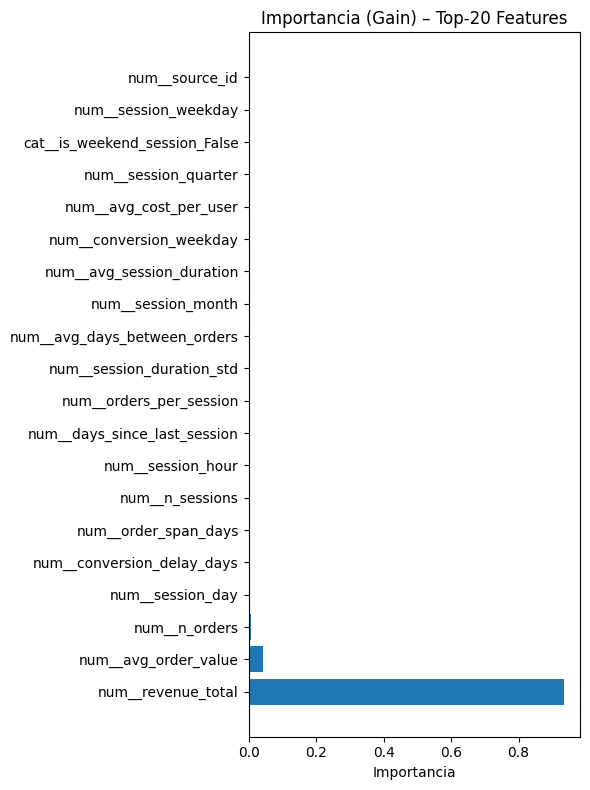

In [16]:
from matplotlib import pyplot as plt

importances = best_ltv_model.named_steps["model"].feature_importances_
idx_sorted  = np.argsort(importances)[::-1][:20]          # top‑20

plt.figure(figsize=(6, 8))
plt.barh(range(len(idx_sorted))[::-1], importances[idx_sorted])
plt.yticks(range(len(idx_sorted))[::-1], feature_names[idx_sorted])
plt.title("Importancia (Gain) – Top‑20 Features")
plt.xlabel("Importancia")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


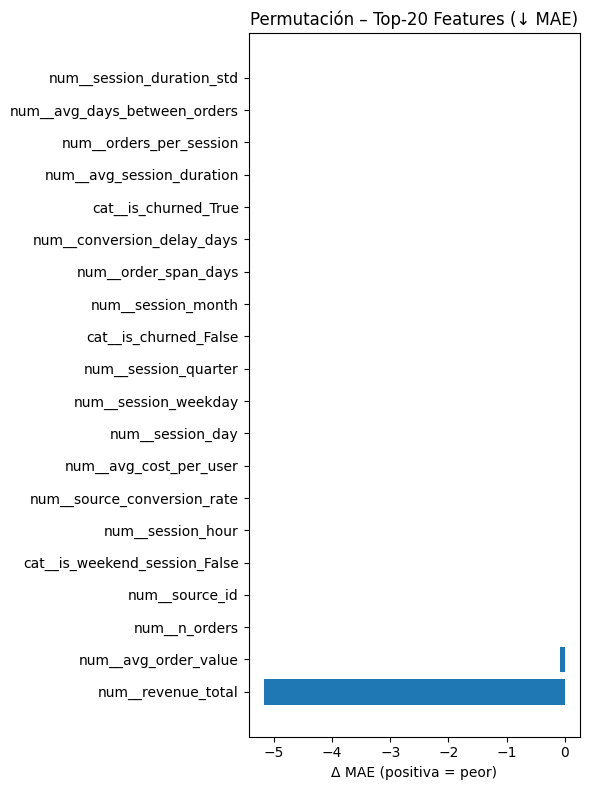

In [17]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, make_scorer

perm = permutation_importance(
    best_ltv_model, X_test, y_test,
    n_repeats=10,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1,
    random_state=42
)

idx_perm = np.argsort(perm.importances_mean)[::-1][:20]

plt.figure(figsize=(6, 8))
plt.barh(range(len(idx_perm))[::-1], -perm.importances_mean[idx_perm])  # neg → pos
plt.yticks(range(len(idx_perm))[::-1], feature_names[idx_perm])
plt.title("Permutación – Top‑20 Features (↓ MAE)")
plt.xlabel("Δ MAE (positiva = peor)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


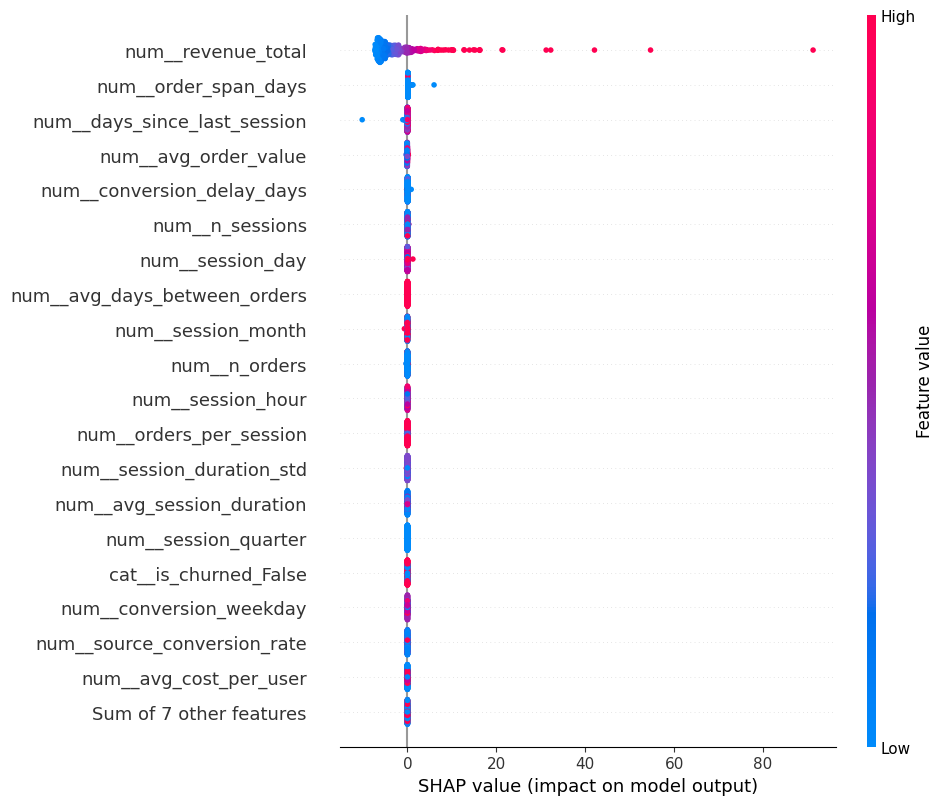

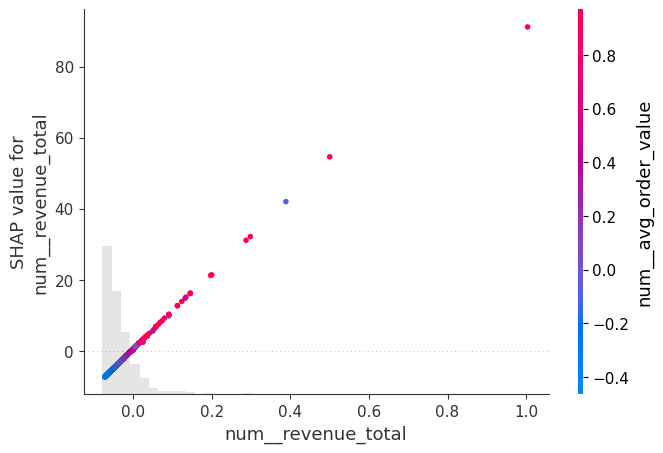

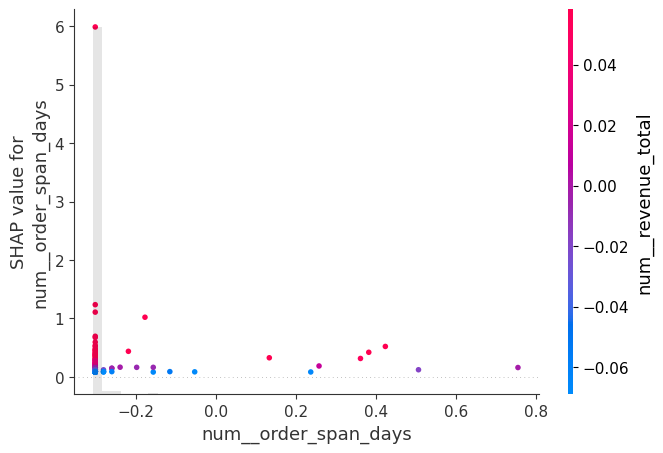

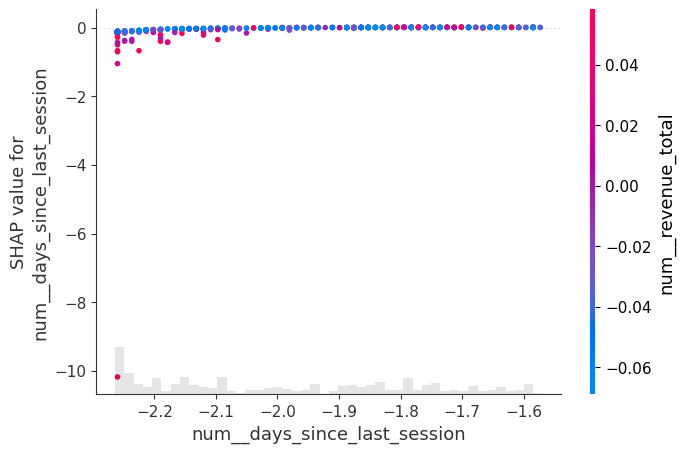

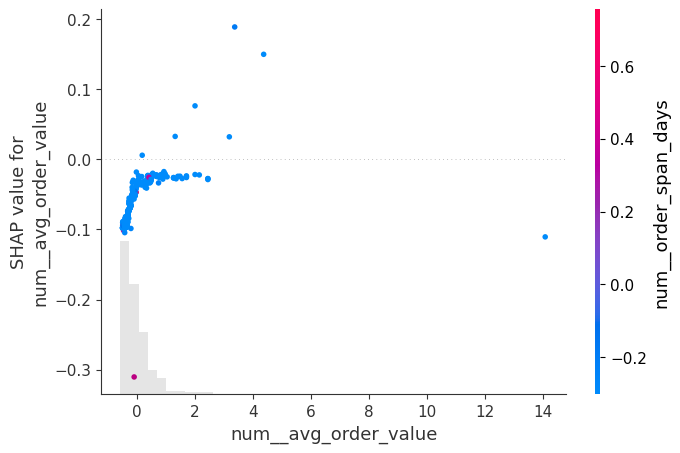

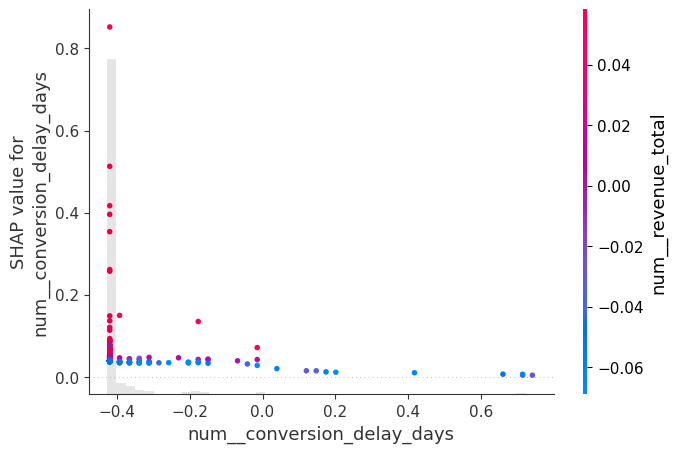

In [18]:

import shap

#  Separar pasos del Pipeline
preprocess   = best_ltv_model.named_steps["preprocess"]
inner_model  = best_ltv_model.named_steps["model"]        # GradientBoostingRegressor

#   Tomar muestra para explicación (500 obs ≈ rápido y estable)
X_sample_raw = X_test.sample(n=500, random_state=42)

#   Transformar la muestra → matriz numérica
X_sample_num = preprocess.transform(X_sample_raw)

#⃣  Obtener nombres de columnas después de OHE/escala
feature_names = preprocess.get_feature_names_out()

#   Convertir a DataFrame para que los gráficos muestren etiquetas
X_sample_num_df = pd.DataFrame(X_sample_num, columns=feature_names)

#  Crear TreeExplainer (optimizado para modelos de árbol)
explainer   = shap.TreeExplainer(inner_model)
shap_values = explainer(X_sample_num_df)

#   Plot global (beeswarm)
shap.plots.beeswarm(shap_values, max_display=20)

#   Plots de dependencia para las 5 variables más influyentes
top_idx = np.argsort(np.abs(shap_values.values).mean(0))[::-1][:5]
for i in top_idx:
    shap.plots.scatter(
        shap_values[:, i],
        color=shap_values,
        show=True               # fuerza despliegue individual en notebooks antiguo
    )


In [ ]:
ltv_test = ltv_test.copy()
ltv_test["pred"]   = best_ltv_model.predict(X_test)
ltv_test["absErr"] = np.abs(ltv_test["pred"] - ltv_test["LTV_180"])

segment_cols = ["device", "source", "country"]          # ⟵ las que te interesen
segment_cols = [c for c in segment_cols if c in ltv_test.columns]  # filtra disponibles

for col in segment_cols:
    seg = (
        ltv_test.groupby(col)["absErr"]
                .mean()
                .sort_values(ascending=False)
                .to_frame("MAE_segmento")
                .head(10)
    )
    print(f"\n--- MAE por {col} ---")
    display(seg)



--- MAE por device ---


,MAE_segmento
device,
desktop,0.204212
touch,0.121920


CAC

In [31]:

# Cargar modelo óptimo
best_cac_model = joblib.load("../models/CAC_source_30_best_tscv.pkl")

# Crear set de prueba (H1‑2018) si no existe en memoria
cac_test = cac_df[(cac_df["first_session"] >= "2018-01-01") &
                  (cac_df["first_session"] <  "2018-07-01")]

cac_X = cac_test.drop(
            columns=['uid', 'first_session', 'last_session',
                     'first_order', 'last_order', 'LTV_180',
                     'CAC_source_30', 'ltv_cohort_avg',
                     'cac_cohort_avg', 'conversion_rate_cohort'],
            errors='ignore')
cac_y = cac_test["CAC_source_30"]


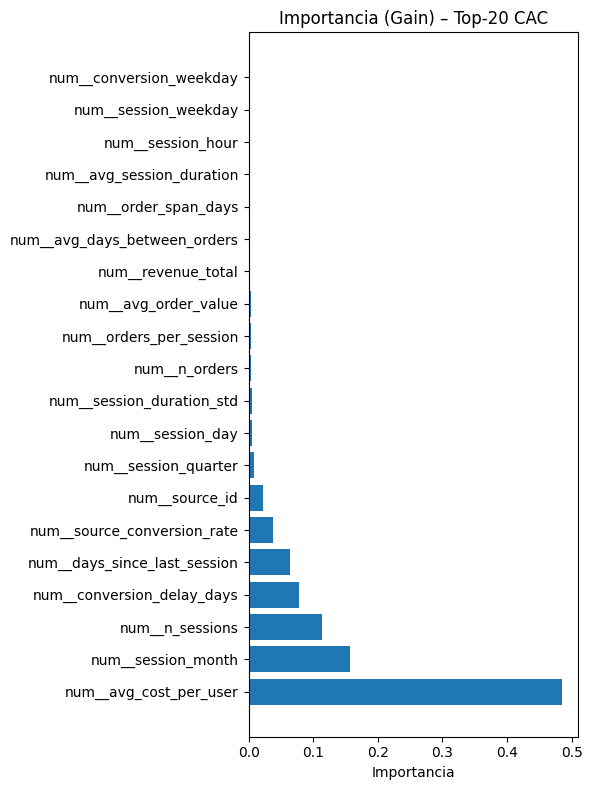

In [32]:
# Importancia de variables gain

feature_names = best_cac_model.named_steps["preprocess"].get_feature_names_out()
gain = best_cac_model.named_steps["model"].feature_importances_
idx = np.argsort(gain)[::-1][:20]

plt.figure(figsize=(6,8))
plt.barh(range(len(idx))[::-1], gain[idx])
plt.yticks(range(len(idx))[::-1], feature_names[idx])
plt.title("Importancia (Gain) – Top‑20 CAC")
plt.xlabel("Importancia")
plt.tight_layout(); plt.gca().invert_yaxis(); plt.show()


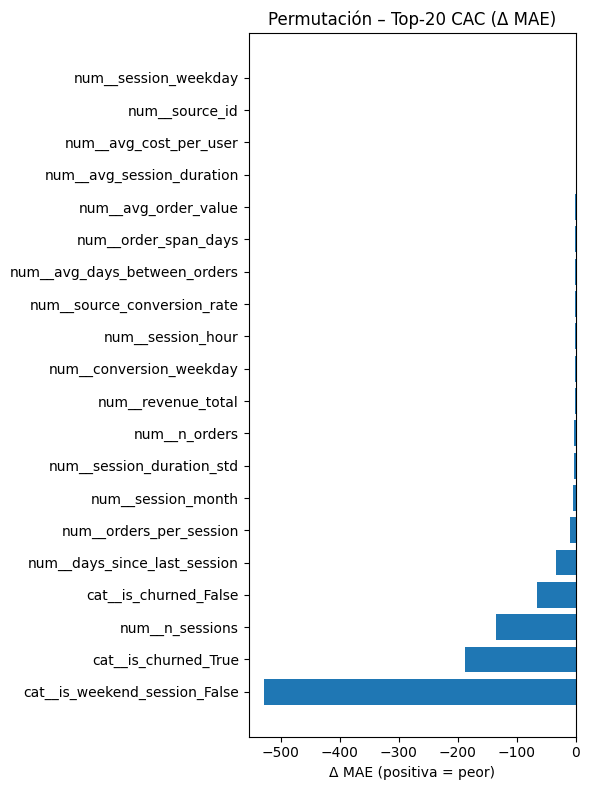

In [33]:
# Importancia de permutacion


perm = permutation_importance(
    best_cac_model, cac_X, cac_y,
    n_repeats=10,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1, random_state=42
)

idxp = np.argsort(perm.importances_mean)[::-1][:20]
plt.figure(figsize=(6,8))
plt.barh(range(len(idxp))[::-1], -perm.importances_mean[idxp])
plt.yticks(range(len(idxp))[::-1], feature_names[idxp])
plt.title("Permutación – Top‑20 CAC (Δ MAE)")
plt.xlabel("Δ MAE (positiva = peor)")
plt.tight_layout(); plt.gca().invert_yaxis(); plt.show()


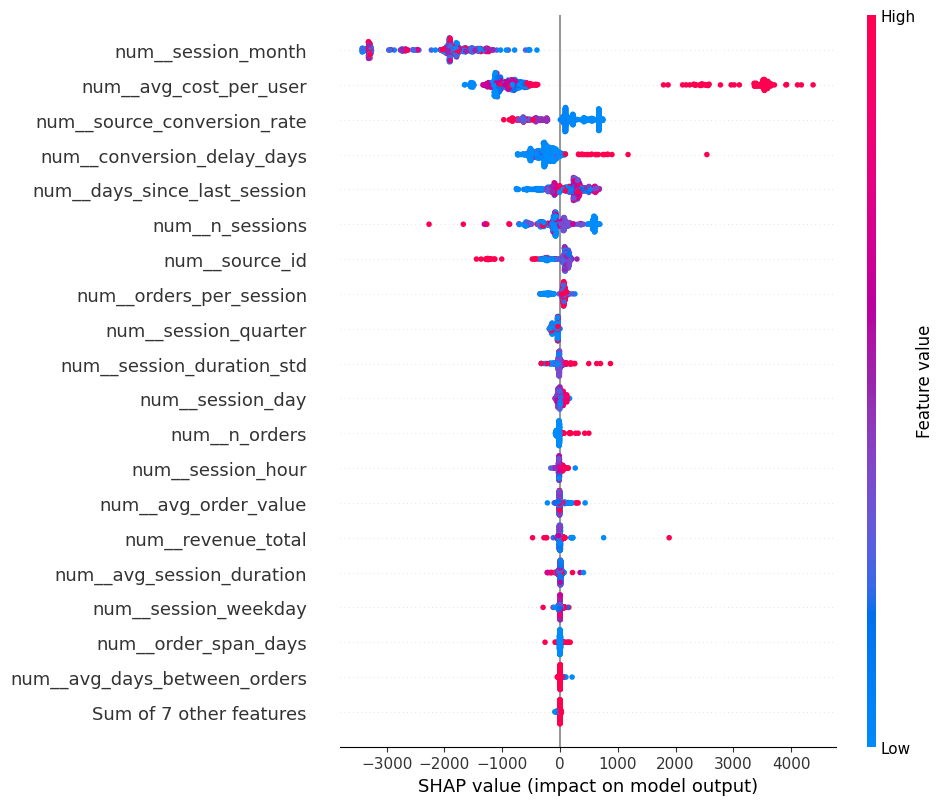

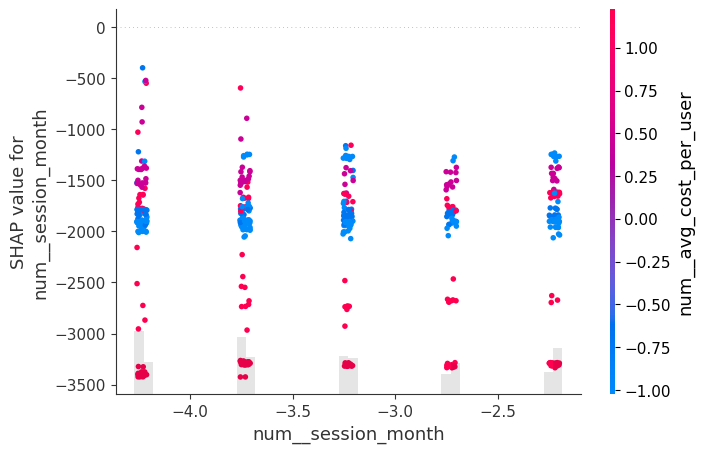

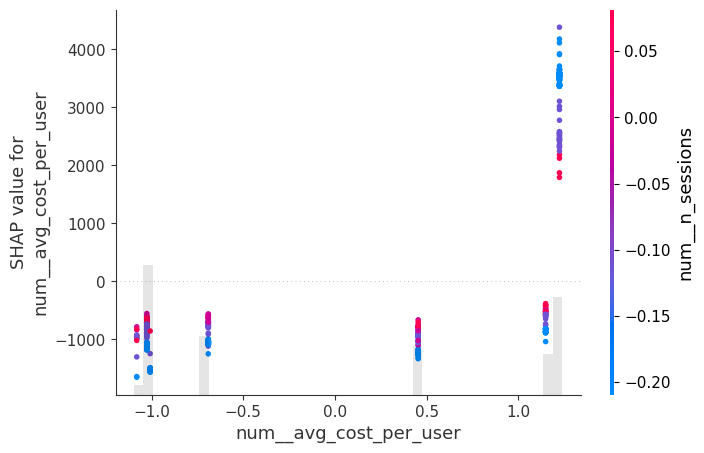

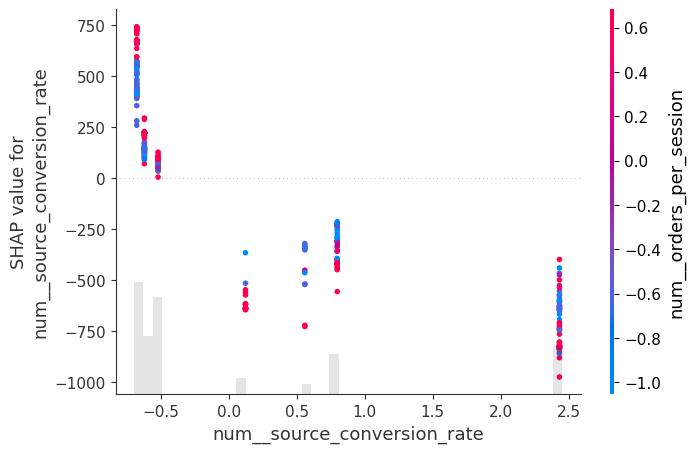

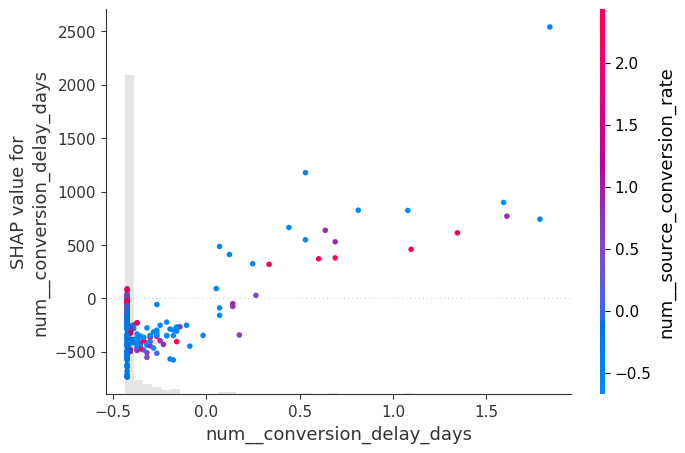

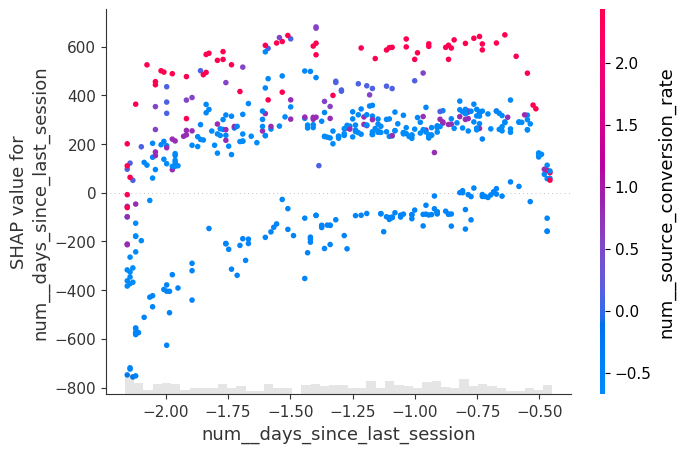

In [34]:

#  Separar pasos
pre_cac  = best_cac_model.named_steps["preprocess"]
mod_cac  = best_cac_model.named_steps["model"]

#  Muestra
X_sample_raw = cac_X.sample(n=500, random_state=42)
X_sample_num = pre_cac.transform(X_sample_raw)
feat_names   = pre_cac.get_feature_names_out()
X_sample_df  = pd.DataFrame(X_sample_num, columns=feat_names)

explainer   = shap.TreeExplainer(mod_cac)
shap_vals   = explainer(X_sample_df)

shap.plots.beeswarm(shap_vals, max_display=20)

top_idx = np.argsort(np.abs(shap_vals.values).mean(0))[::-1][:5]
for i in top_idx:
    shap.plots.scatter(shap_vals[:, i], color=shap_vals)


In [35]:
# Analisis por segmento

cac_test = cac_test.copy()
cac_test["pred"]   = best_cac_model.predict(cac_X)
cac_test["absErr"] = np.abs(cac_test["pred"] - cac_test["CAC_source_30"])

segment_cols = ["device", "source", "country"]
segment_cols = [c for c in segment_cols if c in cac_test.columns]

for col in segment_cols:
    seg = (
        cac_test.groupby(col)["absErr"]
                .mean()
                .sort_values(ascending=False)
                .to_frame("MAE_segmento")
                .head(10)
    )
    print(f"\n--- MAE por {col} ---")
    display(seg)



--- MAE por device ---


,MAE_segmento
device,
desktop,2571.012376
touch,2453.536773
